In [2]:
import random
import torch
import torch.nn.functional as F

words = open('names.txt', 'r').read().splitlines()
chars = sorted(list(set(''.join(words))))
s_to_i = {s: i + 1 for i, s in enumerate(chars)}
i_to_s = {i + 1: s for i, s in enumerate(chars)}
s_to_i['.'] = 0
i_to_s[0] = '.'
block_size = 3
vocab_size = len(i_to_s)
print(f"vocab_size: {vocab_size}")


def build_dataset(words):
    X, Y = [], []
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = s_to_i[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(f"x.shape is {X.shape}, y.shape is {Y.shape}")
    return X, Y


random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))
Xtrain, Ytrain = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xtest, Ytest = build_dataset(words[n2:])

vocab_size: 27
x.shape is torch.Size([182625, 3]), y.shape is torch.Size([182625])
x.shape is torch.Size([22655, 3]), y.shape is torch.Size([22655])
x.shape is torch.Size([22866, 3]), y.shape is torch.Size([22866])


In [33]:
n_embd = 10
n_hidden = 200

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embd), generator=g)
# 初始化应该用kaiming init, 公式是 gain除以根号下fan_in, tanh的gain是 三分之五，fan_in是n_embd * block_size
# W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * 0.2
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5 / 3) / ((n_embd * block_size) ** 0.5)
# batch normalization layer has its own bias,  this bias has not used anymore
# b1的grad基本都是0，对结果影响很小
# b1 = torch.randn(n_hidden, generator=g) * 0.01
# 调小W2 b2可以让第一个epoch的loss较小，从而得到更好的结果
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.01
b2 = torch.randn(vocab_size, generator=g) * 0

# 神经网络普遍会添加batch normalization，一般放在linear layer后
# Batch Normalization 使得每层输入的分布保持相对稳定，有助于加快训练速度，提高模型性能，并且使模型对初始化权重不那么敏感
# the batch normalization caculate the mean and standard deviation of the activations that are feeding into the batch normal layer over that batch
# then it's centering that batch to be unit Gaussian, and then offseting and scaling it by the learned bias and gain
# on top of that, it's keeping track of the mean and standard deviation of the inputs, so we don't have to reestimate the mean/std all the time
bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))

# batch normalization's buffers, mean and standard deviation
# params trained using backpropagation，buffers trained using running mean update
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

params = [C, W1, W2, b2, bngain, bnbias]
for p in params:
    p.requires_grad = True
print(sum(p.nelement() for p in params))

12297


In [34]:
max_steps = 200000
batch_size = 32
lossi = []

for k in range(max_steps):
    ix = torch.randint(0, Xtrain.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtrain[ix], Ytrain[ix]

    # forward
    emb = C[Xb]
    embcat = emb.view(emb.shape[0], -1)
    # Linear layer
    hpreact = embcat @ W1  #+ b1
    # BatchNorm layer
    bnmeani = hpreact.mean(0, keepdim=True)
    bnstdi = hpreact.std(0, keepdim=True)
    hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias
    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi

    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Yb)

    # backward
    for p in params:
        p.grad = None
    loss.backward()

    lr = 0.1 if k < 100000 else 0.01
    for p in params:
        p.data += -lr * p.grad

    if k % 10000 == 0:
        print(f"Epoch: {k}/{max_steps}, loss: {loss.item():}")
    lossi.append(loss.log10().item())

Epoch: 0/200000, loss: 3.3146886825561523
Epoch: 10000/200000, loss: 2.1984431743621826
Epoch: 20000/200000, loss: 2.3374557495117188
Epoch: 30000/200000, loss: 2.4358842372894287
Epoch: 40000/200000, loss: 2.011927604675293
Epoch: 50000/200000, loss: 2.2594728469848633
Epoch: 60000/200000, loss: 2.4774999618530273
Epoch: 70000/200000, loss: 2.1020007133483887
Epoch: 80000/200000, loss: 2.278813123703003
Epoch: 90000/200000, loss: 2.1862072944641113
Epoch: 100000/200000, loss: 1.9473822116851807
Epoch: 110000/200000, loss: 2.301027297973633
Epoch: 120000/200000, loss: 1.9836559295654297
Epoch: 130000/200000, loss: 2.4523186683654785
Epoch: 140000/200000, loss: 2.3839337825775146
Epoch: 150000/200000, loss: 2.198681354522705
Epoch: 160000/200000, loss: 1.9733017683029175
Epoch: 170000/200000, loss: 1.8668081760406494
Epoch: 180000/200000, loss: 1.9972676038742065
Epoch: 190000/200000, loss: 1.834682583808899


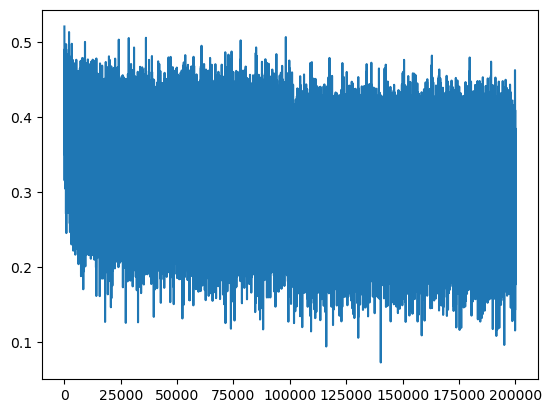

In [26]:
import matplotlib.pyplot as plt

plt.plot(lossi)

(array([2165.,  152.,   94.,   59.,   51.,   49.,   48.,   36.,   35.,
          33.,   42.,   31.,   45.,   30.,   37.,   24.,   17.,   20.,
          20.,   14.,   28.,   17.,   12.,   22.,   34.,   20.,   22.,
          15.,    8.,   26.,   23.,   22.,   24.,   28.,   40.,   15.,
          23.,   36.,   20.,   27.,   21.,   25.,   30.,   53.,   45.,
          64.,   64.,   88.,  115., 2431.]),
 array([-1.  , -0.96, -0.92, -0.88, -0.84, -0.8 , -0.76, -0.72, -0.68,
        -0.64, -0.6 , -0.56, -0.52, -0.48, -0.44, -0.4 , -0.36, -0.32,
        -0.28, -0.24, -0.2 , -0.16, -0.12, -0.08, -0.04,  0.  ,  0.04,
         0.08,  0.12,  0.16,  0.2 ,  0.24,  0.28,  0.32,  0.36,  0.4 ,
         0.44,  0.48,  0.52,  0.56,  0.6 ,  0.64,  0.68,  0.72,  0.76,
         0.8 ,  0.84,  0.88,  0.92,  0.96,  1.  ]),
 <BarContainer object of 50 artists>)

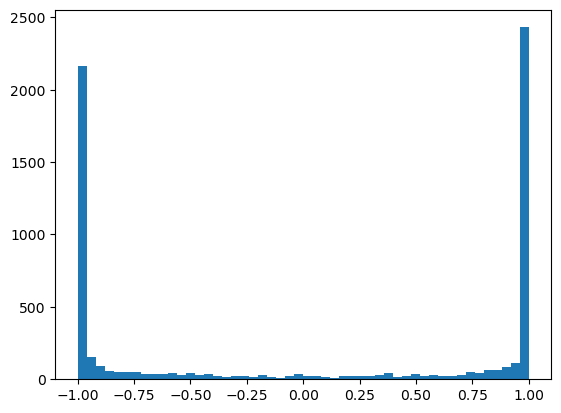

In [19]:
# tanh的分布，太多在1和-1处
plt.hist(h.view(-1).tolist(), 50)

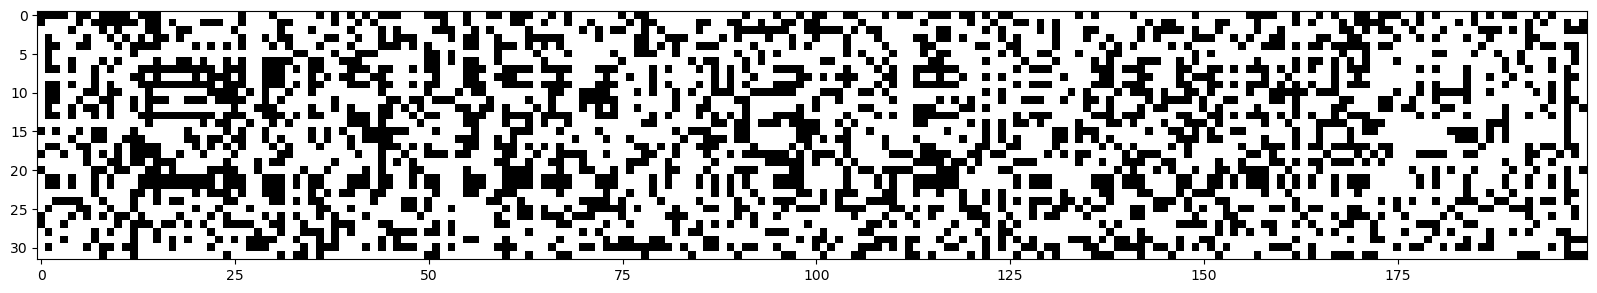

In [23]:
# tanh的反向求导公式是 (1 - t**2)*grad，t太靠近1，就导致grad没有效果
plt.figure(figsize=(20, 10))
# 取h的abs值大于0.99的则显示为白色
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest')
# 其他的激活函数可能也有这个问题，比如sigmoid

In [35]:

@torch.no_grad()
def get_split_loss(split):
    dataset = {
        'train': (Xtrain, Ytrain),
        'dev': (Xdev, Ydev),
        'test': (Xtest, Ytest)
    }
    x, y = dataset[split]
    emb = C[x]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1  #+ b1
    # hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias
    hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(f"{split} loss is {loss.item()}")


get_split_loss("train")
get_split_loss("dev")

train loss is 2.0668270587921143
dev loss is 2.104844808578491


In [29]:
x = torch.tensor([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
x.std()

tensor(1.8708)

In [41]:
"""
以下代码的主要作用：
1. 完全模仿pytorch的接口去实现Linear、BatchNorm1d等
2. BatchNormlization对一个多层神经网络参数初始化的作用
3. 如何通过图表观察当前的参数情况
"""


class Linear:
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in ** 0.5
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out

    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])


class BatchNorm1d:
    """
    参考pytorch文档上的公式 https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm1d.html#batchnorm1d
    xmean就是E[x], xvar就是Var[x]
    """

    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # params
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # buffers
        self.running_mean = torch.zeros(dim)
        self.runnning_var = torch.ones(dim)

    def __call__(self, x):
        if self.training:
            xmean = x.mean(0, keepdim=True)
            xvar = x.var(0, keepdim=True)
        else:
            xmean = self.running_mean
            xvar = self.runnning_var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
        self.out = self.gamma * xhat + self.beta
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.runnning_var = (1 - self.momentum) * self.runnning_var + self.momentum * xvar
        return self.out

    def parameters(self):
        return [self.gamma, self.beta]


class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out

    def parameters(self):
        return []

In [85]:

n_embd = 10
n_hidden = 100
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embd), generator=g)
# without batch norm
# layers = [
#     Linear(n_embd * block_size, n_hidden), Tanh(),
#     Linear(n_hidden, n_hidden), Tanh(),
#     Linear(n_hidden, n_hidden), Tanh(),
#     Linear(n_hidden, n_hidden), Tanh(),
#     Linear(n_hidden, n_hidden), Tanh(),
#     Linear(n_hidden, vocab_size)
# ]
# add batch norm
layers = [
    Linear(n_embd * block_size, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size), BatchNorm1d(vocab_size)
]

with torch.no_grad():
    # 最后一层减少模型对其预测的自信程度
    # layers[-1].weight *= 0.1
    layers[-1].gamma *= 0.1
    # 其他层加上gain的权重，如果不用 5/3，则saturation将变成0，也就是说distribution会逐渐收缩
    # 因为tanh函数本身会squashing， 所以我们需要expanding，所以测试出5/3是更好的值
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 1  #5 / 3

params = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in params))
for p in params:
    p.requires_grad = True

47551


In [86]:
max_steps = 200000
batch_size = 32
lossi = []
ud = []

for k in range(max_steps):
    ix = torch.randint(0, Xtrain.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtrain[ix], Ytrain[ix]

    # forward
    emb = C[Xb]
    x = emb.view(emb.shape[0], -1)
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb)

    # backward
    for layer in layers:
        layer.out.retain_grad()
    for p in params:
        p.grad = None
    loss.backward()

    lr = 0.1 if k < 100000 else 0.01
    for p in params:
        p.data += -lr * p.grad

    if k % 10000 == 0:
        print(f"Epoch: {k}/{max_steps}, loss: {loss.item():}")
    lossi.append(loss.log10().item())
    with torch.no_grad():
        ud.append([((lr * p.grad).std() / p.data.std()).log10().item() for p in params])

    if k >= 1000:
        break

Epoch: 0/200000, loss: 3.2870309352874756


layer 2(Tanh): mean -0.00, std 0.63, saturated 2.78%
layer 5(Tanh): mean 0.00, std 0.64, saturated 2.56%
layer 8(Tanh): mean -0.00, std 0.65, saturated 2.25%
layer 11(Tanh): mean 0.00, std 0.65, saturated 1.69%
layer 14(Tanh): mean 0.00, std 0.65, saturated 1.88%


Text(0.5, 1.0, 'activation distribution')

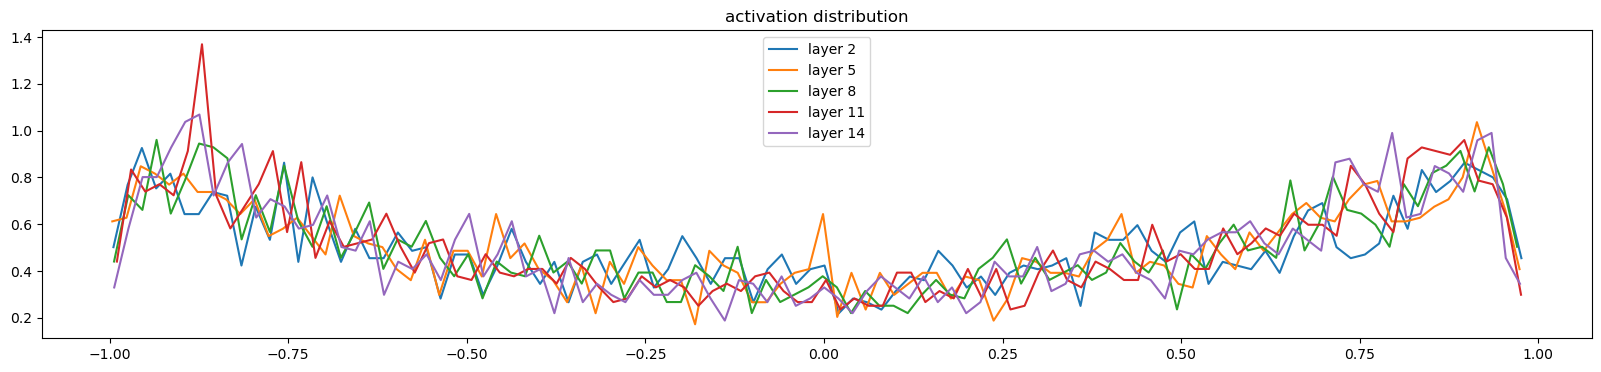

In [92]:
# 多层神经网络，out的分布图，关注其在不同层之间的变化，以及权重5/3变为太小的值0.5或太大的值3的变化
plt.figure(figsize=(20, 4))  # 图的尺寸
legends = []
for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Tanh):
        t = layer.out
        layer_name = layer.__class__.__name__
        # 饱和度：激活函数输出值大于0.97的比例；饱和度过高会导致梯度消失
        saturation = (t.abs() > 0.97).float().mean() * 100
        print(f"layer {i}({layer_name}): mean {t.mean():.2f}, std {t.std():.2f}, saturated {saturation:.2f}%")
        # 横坐标表示区间范围，纵坐标在density为False时表示该区间内值的数量，为True时表示该区间值的密度
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f"layer {i}")
plt.legend(legends)
plt.title('activation distribution')

layer 2(Tanh): mean -6.984919153490976e-12, std 0.00264070020057261, saturated 0.00%
layer 5(Tanh): mean -2.328306384496992e-12, std 0.0022455824073404074, saturated 0.00%
layer 8(Tanh): mean 9.895302459372868e-12, std 0.0020457403734326363, saturated 0.00%
layer 11(Tanh): mean -9.022187510976387e-12, std 0.0019831317476928234, saturated 0.00%
layer 14(Tanh): mean -1.0331859499890239e-11, std 0.0019523808732628822, saturated 0.00%


Text(0.5, 1.0, 'gradient distribution')

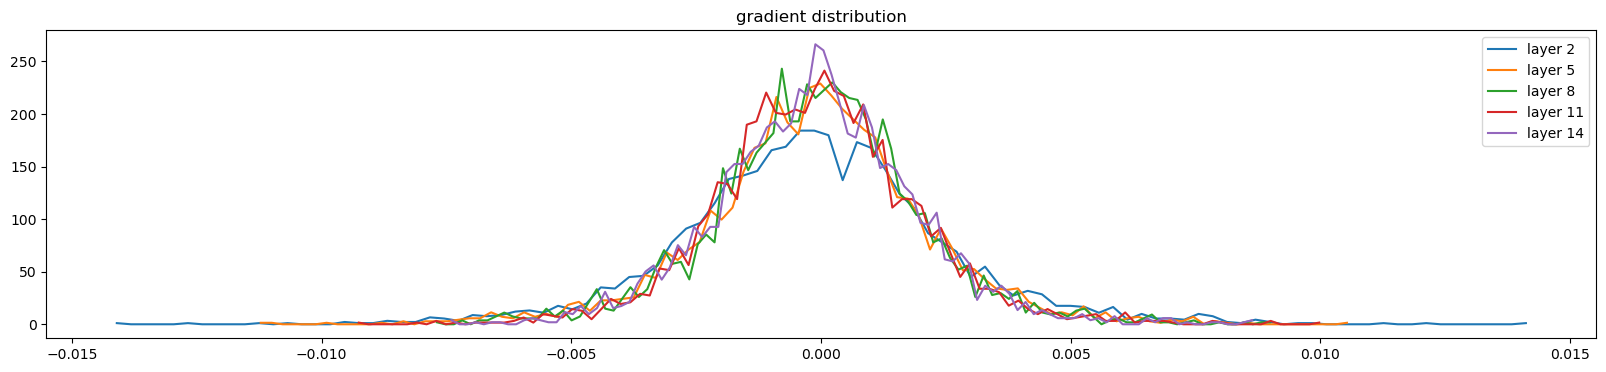

In [88]:
# grad的分布图
plt.figure(figsize=(20, 4))
legends = []
for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Tanh):
        t = layer.out.grad
        layer_name = layer.__class__.__name__
        saturation = (t.abs() > 0.97).float().mean() * 100
        print(f"layer {i}({layer_name}): mean {t.mean()}, std {t.std()}, saturated {saturation:.2f}%")
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f"layer {i}")
plt.legend(legends)
plt.title('gradient distribution')

weight (27, 10) | mean -0.000000 | std 8.020525e-03 | grad:data ratio 8.012621e-03
weight (30, 100) | mean 0.000246 | std 9.241067e-03 | grad:data ratio 4.881085e-02
weight (100, 100) | mean 0.000113 | std 7.132872e-03 | grad:data ratio 6.964613e-02
weight (100, 100) | mean -0.000086 | std 6.234298e-03 | grad:data ratio 6.073734e-02
weight (100, 100) | mean 0.000052 | std 5.742178e-03 | grad:data ratio 5.631474e-02
weight (100, 100) | mean 0.000032 | std 5.672199e-03 | grad:data ratio 5.570119e-02
weight (100, 27) | mean -0.000082 | std 1.209415e-02 | grad:data ratio 1.160105e-01


Text(0.5, 1.0, 'weights gradient distribution')

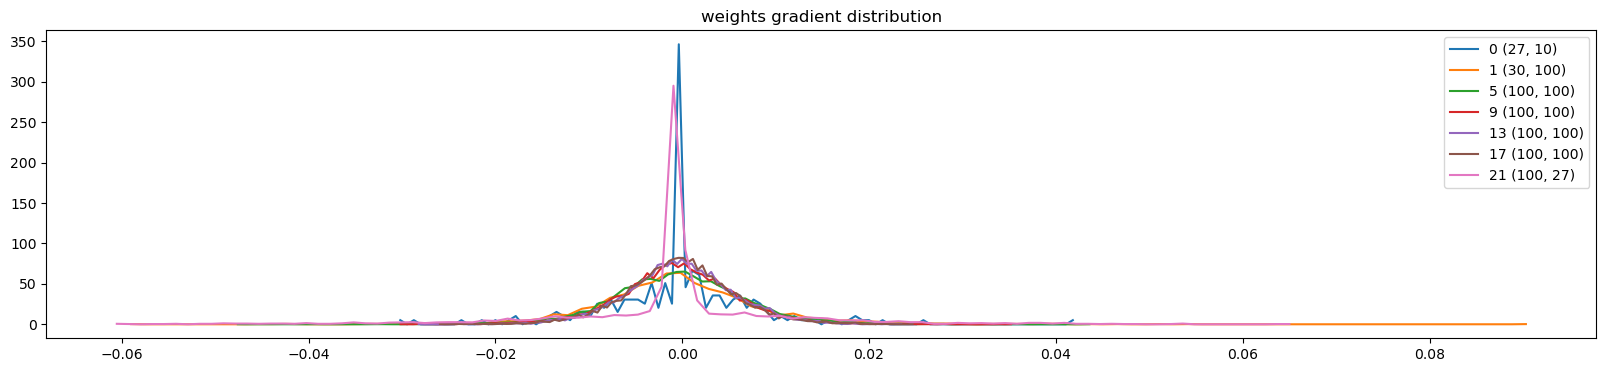

In [89]:
# parameters的分布图
plt.figure(figsize=(20, 4))
legends = []
for i, p in enumerate(params):
    t = p.grad
    # 只关注二维的参数，舍弃关注bias、gamma、beta等参数来让问题简单一些
    if p.ndim == 2:
        print(f"weight {tuple(p.shape)} | mean {t.mean():f} | std {t.std():e} | grad:data ratio {t.std() / p.std():e}")
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f"{i} {tuple(p.shape)}")
plt.legend(legends)
plt.title('weights gradient distribution')

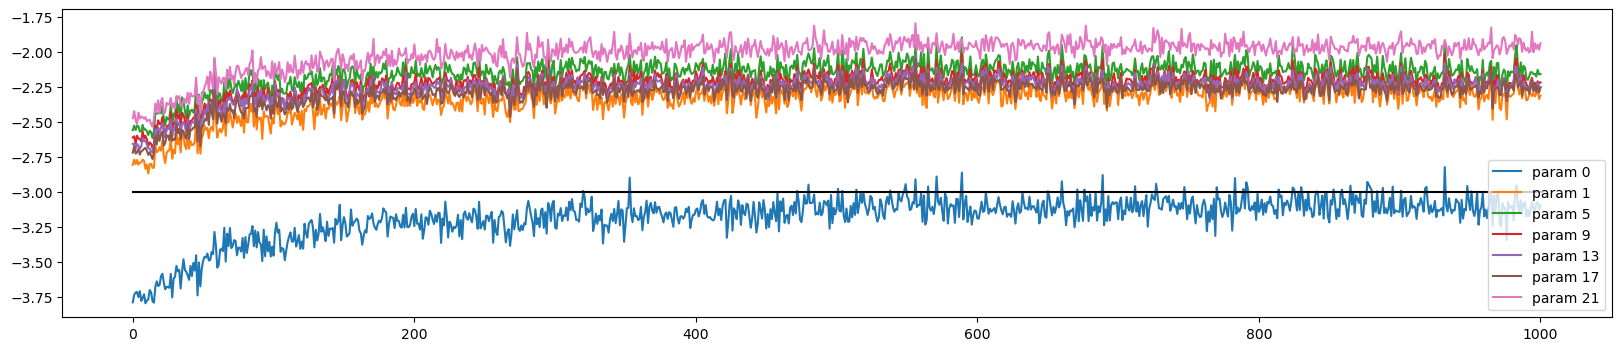

In [90]:
plt.figure(figsize=(20, 4))
legends = []
for i, p in enumerate(params):
    if p.ndim == 2:
        plt.plot([ud[j][i] for j in range(len(ud))])
        legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k')  # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);